In [1]:
import gurobipy as gp
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

from markowitz import Markowitz
from markowitz import par

In [2]:
def limpa(s):
    return s.replace("/","").replace("-","").replace(".","").replace("$","").replace("R","")

def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

In [3]:
df = pd.read_excel('seriehistorica.xlsx')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.fillna(method='ffill',inplace=True)

In [4]:
pf = pd.read_excel('perfilfundos.xlsx')
pf.drop(['NOME','DATA_INICIO','CARENCIA','FLAG_QUALIFICADO'],axis=1,inplace=True)
pf['CNPJ'] = pf['CNPJ'].apply(limpa)
pf['APLICACAO_MINIMA'] = pd.to_numeric(pf['APLICACAO_MINIMA'].apply(limpa),errors='coerce')
pf.fillna(0,inplace=True)
pf.set_index('CNPJ',inplace=True)
pf_ordered = pf.sort_values(by ='CATEGORIA')
pf_ordered.drop(index=(list(set(pf.index)-set(df.columns))),inplace=True)

In [5]:
list(pf_ordered['CATEGORIA'].unique())

['Ações', 'Cambial', 'Multimercados', 'Renda Fixa']

In [6]:
categorias = list(pf_ordered['CATEGORIA'].unique())

limites = [0]

a = 0

for c in categorias:
    a += len(pf_ordered[pf_ordered['CATEGORIA'] == c])
    limites.append(a)

print(limites)

[0, 173, 177, 474, 569]


In [7]:
cnpj = list(pf_ordered.index)
df = df[cnpj]

In [8]:
df

,00601692000123,17397804000179,17253801000161,33824951000134,10756685000154,17787909000134,18558694000142,18298864000105,32812185000125,11741429000156,...,14237118000142,14171644000157,14115118000170,23714047000112,35726805000100,27932660000167,14188162000100,30921203000181,30910553000142,27717045000138
0,9476.238717,2.725072,230.083435,1.046469,4.746801,2.260868,2.835142,1.970838,107.189288,4.222595,...,2.273824,2.210487,2.738843,10.561692,1.013091,1.069223,2.185507,1.096534,1.098701,1133.645644
1,9492.145359,2.730746,230.583512,1.052654,4.759999,2.263318,2.876591,1.947510,108.257177,4.201679,...,2.274469,2.210556,2.742564,10.565436,1.013171,1.069712,2.185962,1.096746,1.099068,1133.072720
2,9553.200253,2.702602,229.758098,1.036770,4.746166,2.264003,2.868424,1.982873,109.125354,4.147773,...,2.275201,2.211370,2.733812,10.561309,1.013489,1.069716,2.186331,1.096750,1.098963,1133.635290
3,9619.547344,2.747348,230.940758,1.049486,4.797380,2.288290,2.851524,1.989195,109.888268,4.199290,...,2.275702,2.212492,2.741189,10.567026,1.013621,1.070110,2.187023,1.097007,1.099404,1134.137538
4,9374.414235,2.685006,228.070824,1.023026,4.698439,2.228894,2.835739,1.989170,107.191479,4.093083,...,2.276020,2.212905,2.727827,10.562323,1.013640,1.069958,2.187276,1.096997,1.099369,1133.160741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,9855.075475,2.675408,257.478207,1.198670,5.848024,2.540130,3.197036,2.302362,109.086509,4.909076,...,2.397460,2.354895,2.809082,11.162081,1.037270,1.123219,2.315001,1.154868,1.176940,1198.768566
248,9777.223794,2.643776,253.182522,1.189572,5.775198,2.531583,3.204305,2.272741,106.653733,4.865191,...,2.398257,2.356297,2.795630,11.167268,1.037481,1.123563,2.315906,1.155241,1.177348,1199.217778
249,9774.313705,2.653076,254.260353,1.196228,5.752762,2.546687,3.163585,2.293661,106.260859,4.885949,...,2.398988,2.357508,2.799673,11.170731,1.037741,1.124061,2.316594,1.155610,1.177725,1199.590351
250,9576.696583,2.625754,249.479127,1.161523,5.657703,2.496497,3.143159,2.312158,103.945179,4.786635,...,2.399779,2.358092,2.786669,11.175085,1.037953,1.124395,2.317073,1.155876,1.177947,1199.023280


In [9]:
df_retorno = df.pct_change().dropna()
sigma = (df_retorno.cov()*252).to_numpy()
#media = df_retorno.mean().values*252
media = (df_retorno+1).apply(geo_mean)**252-1

In [10]:
minFundos = np.array(pf_ordered['APLICACAO_MINIMA'])

n = len(minFundos)

In [11]:
minRetorno = 0.55
C = 10_000
P_categorias = [0.25, 0.0, 0.35, 0.4]
K_min = 3
K_max = 10
P_min = 0.05
P_max = 0.3
l = 1
log = 0

In [12]:
parametros = par(C, minRetorno, K_min, K_max, P_min, P_max, P_categorias, limites, n, log)

In [13]:
parametros.Exibir_par()

P_min = 5.0%
P_max = 30.0%
K_min = 4
K_max = 10
P_categorias = [0.25, 0.0, 0.35, 0.4]


In [14]:
import time

tempo_init = time.time()
Carteira = Markowitz(minFundos, sigma, media, cnpj, parametros);
print('Tempo total:', time.time() - tempo_init, 's')

Carteira.Exibir(C)

Academic license - for non-commercial use only - expires 2021-11-05
Using license file /home/vinicius/gurobi.lic
Tempo total: 2.0212738513946533 s
Retorno esperado --> 0%
Risco estimado --> 0%


In [15]:
categoria = np.array(pf['CATEGORIA'][Carteira.descricao])
subcategoria = np.array(pf['SUBCATEGORIA'][Carteira.descricao])

for i in range(len(categoria)):
    print(f"{Carteira.descricao[i]} --> {categoria[i]} --> {subcategoria[i]}")

In [35]:
minRetorno = 0.0
C = 10_000
P_categorias = [0.25, 0.0, 0.35, 0.4]
K_min = 1
#aux = 4
#max(len(P_categorias), aux)
K_max = 10
P_min = 0.05
P_max = 0.3 #max(P_categorias)
log = 0

a_retorno = []
a_risco = []
a_sharpe = []

RES = dict()
k = 0

tempo_init = time.time()

while minRetorno <= 1:
    parametros = par(C, minRetorno, K_min, K_max, P_min, P_max, P_categorias, limites, n, log)
    Carteira = Markowitz(minFundos, sigma, media, cnpj, parametros)
    if Carteira.Risco != 0:
        a_sharpe.append((Carteira.Retorno - 0.0525)/Carteira.Risco)
        a_retorno.append(Carteira.Retorno)
        a_risco.append(Carteira.Risco)
        RES[k] = Carteira
    minRetorno = minRetorno + 0.01
    k += 1
    
print('Tempo total:', time.time() - tempo_init, 's')

Tempo total: 247.82766199111938 s


In [36]:
max_i = np.argmax(a_sharpe)
print(a_sharpe[max_i])

6.88873953651461


In [37]:
parametros.Exibir_par()

P_min = 5.0%
P_max = 30.0%
K_min = 4
K_max = 10
P_categorias = [0.25, 0.0, 0.35, 0.4]


In [38]:
import matplotlib.colors as mcolors

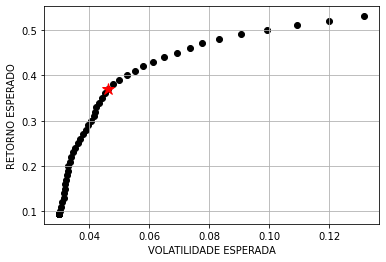

In [39]:
fig = plt.figure()
plt.grid()
plt.scatter(a_risco,a_retorno,c='k')
plt.plot(a_risco[max_i], a_retorno[max_i], '*r', markersize='12')
#plt.ylim((0,1.25))
#plt.xlim((-0.01,0.7))
plt.xlabel('VOLATILIDADE ESPERADA')
plt.ylabel('RETORNO ESPERADO')
plt.show()

In [40]:
RES[max_i].Exibir(C)

Retorno esperado --> 37.0%
Risco estimado --> 4.61%
Fundo 63 (29177024000100) --> 14.32%; R$ 1431.94 --> R$ 250.0
Fundo 113 (08968733000126) --> 10.68%; R$ 1068.06 --> R$ 250.0
Fundo 242 (33736873000116) --> 5.0%; R$ 500.0 --> R$ 500.0
Fundo 268 (36327569000103) --> 5.0%; R$ 500.0 --> R$ 100.0
Fundo 447 (19959703000170) --> 5.0%; R$ 500.0 --> R$ 0.0
Fundo 470 (21732619000160) --> 20.0%; R$ 2000.0 --> R$ 1000.0
Fundo 489 (26759909000111) --> 10.0%; R$ 1000.0 --> R$ 1000.0
Fundo 524 (30934757000113) --> 30.0%; R$ 3000.0 --> R$ 1000.0


In [41]:
categoria = np.array(pf['CATEGORIA'][RES[max_i].descricao])
subcategoria = np.array(pf['SUBCATEGORIA'][RES[max_i].descricao])

for i in range(len(RES[max_i].descricao)):
    print(f"{RES[max_i].descricao[i]} --> {categoria[i]} --> {subcategoria[i]}")

29177024000100 --> Ações --> Ações Dividendos
08968733000126 --> Ações --> Ações Livre
33736873000116 --> Multimercados --> Multimercados Estratégia Específica
36327569000103 --> Multimercados --> Multimercados Investimento no Exterior
19959703000170 --> Multimercados --> Multimercados Macro
21732619000160 --> Multimercados --> Multimercados Investimento no Exterior
26759909000111 --> Renda Fixa --> Renda Fixa Duração Livre Crédito Livre
30934757000113 --> Renda Fixa --> Renda Fixa Duração Livre Crédito Livre


In [ ]:
RES.keys()